In [8]:
import numpy as np
import math 
import bitarray
from math import *
from matplotlib import pyplot as plt

# Basics : Root raised cosine, Fourier transform

In [9]:
f_s = 22050
T_s = 1/f_s
sigma = 0.05

In [10]:
def fourier_transform(x, start, end):
    nb_coef = end - start
    result = np.zeros(nb_coef)
    n = np.arange(x.shape[0])
    for f in np.arange(start, end):
        result[f - start] = np.abs(np.sum(x/f_s * np.exp(-2*1j*pi* f * (n/f_s))))
    
    return result

In [11]:
B = 0.8
T = 2

def root_raised_cos_(t, T):
    if t == np.abs(T/(4*B)) : 
        return B/(pi*sqrt(2*T)) * ((pi + 2)*np.sin(pi/(4*B)) + (pi - 2)*cos(pi/(4*B)))
    else :
        return 4*B / (pi*sqrt(T)) * (cos((1+B)*pi*t/T) + (1-B)*pi/(4*B)*np.sinc((1-B)*t/T))/ (1 - (4*B*t/T)**2)

In [12]:
root_raised = np.vectorize(root_raised_cos_v2)

In [14]:
nb_samples_root_raised = 200
n_T = 10 # number of samples to get to T in the root raised cosinus n_t = T/Ts
n = nb_samples_root_raised//2
t_s = np.arange(-n, n)/f_s
root_raised_10_Ts = root_raised(t_s, n_T*T_s)
root_raised_10_Ts_rescaled = root_raised_10_Ts/(np.max(root_raised_10_Ts)*3/2)

In [16]:
basis_2 = root_raised_10_Ts_rescaled

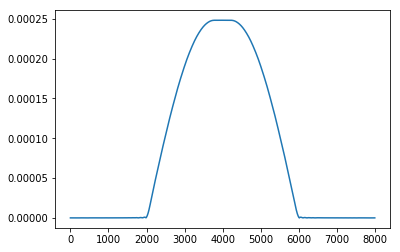

In [17]:
plt.plot(fourier_transform(basis_2, -4000, 4000))

# Text-to-bit, Bit-to-text, B-to-UnitEnergySignal

In [19]:
def text_to_bit(text):
    ba = bitarray.bitarray()
    ba.frombytes(text.encode('utf-8'))
    ba = np.fromiter(map(lambda x : 1 if x else 0, ba.tolist()), dtype = int)
    return ba

In [20]:
def bit_to_text(bit):
    ba = bitarray.bitarray(bit.tolist())
    r = ba.tobytes()
    return  str(r,'utf8')

In [21]:
#right now convert (0,1) array to (-1 , 1) array
def b_to_c(array):
    c_s = (array -1/2)*2
    return c_s

In [23]:
def transmitter(text_file):
    text_size = text_file.shape[0]
    result = np.zeros(nb_samples_root_raised + n_T * (text_size -1))

    for i in range(text_size) :
        #print(text_file[i]*root_raised_12_Ts_rescaled)
        result[n_T*i : nb_samples_root_raised + n_T*i] += text_file[i]*root_raised_12_Ts_rescaled
    return result
    

In [24]:
def decode(array) :
    #print(array.shape)
    size_sent = int((len(array)-nb_samples_root_raised)/n_T + 1)
    result = np.zeros(size_sent)
    for i in range(size_sent):
        #result[i] = np.sum(basis_2 * array[n_T*i : 200+n_T*i])
        result[i] = np.sum(root_raised_12_Ts_rescaled * array[n_T*i : 200+n_T*i])
    return (np.sign(result)+1)/2 

In [34]:
def create_random(size):
    random_text =  np.sign(np.random.rand(size) -0.5)
    
    return random_text

In [35]:
def low_pass(arr, f_0):
    T = 2*f_0
    t = np.arange(-200,200)/f_s
    sinc = T * np.sinc(T*t)
    
    return np.convolve(arr/f_s, sinc, mode = 'same')

In [37]:
def shift(arr, f_0):
    indices = np.arange(arr.shape[0])
    return (arr * np.sqrt(2) * np.exp(1j * 2 * pi * f_0 * indices/f_s))/np.sqrt(2)

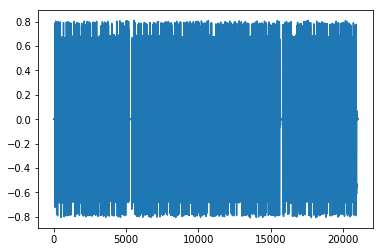

In [39]:
string_text = "przswYniLnjyaC3tw3A1S6DsnU4SNJzDeMMg7GrWUDLwyuzHMhNaTKvDtNVlGEFWjNNgQwon48Thz8hkdJWLbqUcRNt0r0DXatMjaplaE1A6NvTYScDu33HUsYiWurtK"
#string_text = "Carapz il roule tout pété dérrière la nib's"
random_size = int(50*len(string_text)/100)
start_random = create_random(8*random_size)
end_random = create_random(8*random_size)
constellation = b_to_c(text_to_bit(string_text))
size_sent = len(constellation)

#constellation = np.concatenate( (start_random, constellation, end_random) , axis = 0)
a_transmitted = transmitter(constellation)


#a_transmitted = np.concatenate( (start_random,a_transmitted, end_random), axis = 0)
start_transmitted = transmitter(start_random)
end_transmitted = transmitter(end_random)
message_transmitted = np.concatenate((start_transmitted, a_transmitted, end_transmitted))
plt.plot(message_transmitted)
convolution_start = np.correlate(message_transmitted,start_transmitted , mode = 'valid')
convolution_end = np.correlate(message_transmitted,end_transmitted , mode = 'valid')
max_before_channel = np.max(convolution_start)

f_1= 3000 # first value to shift
f_2 = 7000 # second value to shift 
message_transmitted_shifted_f1 = shift(message_transmitted,f_1)
message_transmitted_shifted_f2 = shift(message_transmitted, f_2)
start_transmitted_f1 = message_transmitted_shifted_f1[:len(start_transmitted)]
end_transmitted_f1 = message_transmitted_shifted_f1[-len(end_transmitted):]
start_transmitted_f2 = message_transmitted_shifted_f2[:len(start_transmitted)]
end_transmitted_f2 = message_transmitted_shifted_f2[-len(end_transmitted):]

message_transmitted = (message_transmitted_shifted_f1 + message_transmitted_shifted_f2)
message_transmitted = np.real(message_transmitted)

In [40]:
start = np.argmax(convolution_start)+len(start_transmitted)
end = np.argmax(convolution_end)
#print(end-start)
print(a_transmitted.shape)
print(message_transmitted[start:end].shape)
print(start, end)
#plt.plot(convolution_start[100:250][60:80])

(10430,)
(10430,)
5310 15740


In [41]:
output = np.convolve(shift(root_raised_12_Ts_rescaled, 3000), message_transmitted)

In [43]:
start = np.argmax(np.correlate(output, start_transmitted_f1)) + len(start_transmitted_f1)
end = np.argmax(np.correlate(output, end_transmitted_f1))
output_truncated = np.real(low_pass(shift(output[start:end], -f_1), 2000))
print(bit_to_text(decode(-output_truncated)))
print(start, end)
print(bit_to_text(decode(-output_truncated)) == string_text)

przswYniLnjyaC3tw3A1S6DsnU4SNJzDeMMg7GrWUDLwyuzHMhNaTKvDtNVlGEFWjNNgQwon48Thz8hkdJWLbqUcRNt0r0DXatMjaplaE1A6NvTYScDu33HUsYiWurtK
5413 15843
True


In [44]:
print(a_transmitted.shape, end-start)

(10430,) 10430


In [45]:
np.savetxt('input.txt', message_transmitted)

In [46]:
!python3 client.py --input_file='input.txt' --output_file='output.txt' --srv_hostname=iscsrv72.epfl.ch --srv_port=80

Traceback (most recent call last):
  File "client.py", line 64, in <module>
    sock_cl.connect((args.srv_hostname, args.srv_port))
ConnectionRefusedError: [Errno 111] Connection refused


In [78]:
#output = np.loadtxt('output.txt')
shifted = np.concatenate((np.zeros((1000)), message_transmitted, np.zeros((1000))), axis = 0)
output = shifted + np.random.normal(0, 0.05, np.shape(shifted)[0])

In [79]:
f_trans = fourier_transform(output,1000,9000)

In [80]:
norm_1 = np.linalg.norm(f_trans[:2000])
norm_2 = np.linalg.norm(f_trans[2000:4000])
norm_3 = np.linalg.norm(f_trans[4000:6000])
norm_4 = np.linalg.norm(f_trans[6000:8000])
fallen_index = np.argmin(np.array([norm_1, norm_2, norm_3, norm_4]))

#######
#fallen_index = 2
######

print("Part {} has fallen".format(fallen_index +1 ))
fallen_index = 4

Part 4 has fallen


In [81]:
if fallen_index < 2:
    output = np.convolve(shift(root_raised_12_Ts_rescaled, 7000), message_transmitted)
    start = np.argmax(np.correlate(output, start_transmitted_f2)) + len(start_transmitted_f1)
    end = np.argmax(np.correlate(output, end_transmitted_f2))
    output_truncated = np.real(low_pass(shift(output[start:end], -f_2), 2000))

else :
    output = np.convolve(shift(root_raised_12_Ts_rescaled, 3000), message_transmitted)
    start = np.argmax(np.correlate(output, start_transmitted_f1)) + len(start_transmitted_f1)
    end = np.argmax(np.correlate(output, end_transmitted_f1))
    output_truncated = -np.real(low_pass(shift(output[start:end], -f_1), 2000))

a = bit_to_text(decode(output_truncated))
print(a == string_text)
print(a)

True
przswYniLnjyaC3tw3A1S6DsnU4SNJzDeMMg7GrWUDLwyuzHMhNaTKvDtNVlGEFWjNNgQwon48Thz8hkdJWLbqUcRNt0r0DXatMjaplaE1A6NvTYScDu33HUsYiWurtK


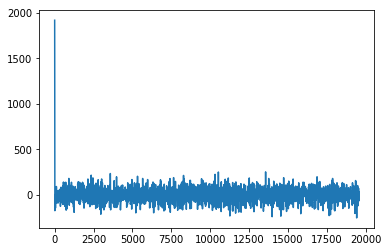

In [98]:
plt.plot(convolution_start)

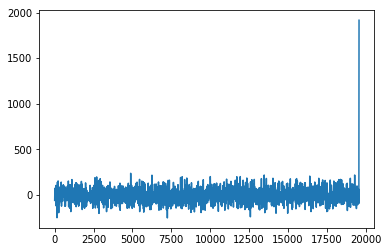

In [99]:
plt.plot(convolution_end)

In [68]:
#start = np.argmax(convolution_start - norm_start*convolved_norm_output) + len(transformed_start)//2
#end = np.argmax(convolution_end - norm_end*convolved_norm_output) - len(transformed_start)//2
start = np.argmax(np.abs(convolution_start))+len(start_transmitted)
end =  np.argmax(np.abs(convolution_end))
print(start, end)

1870 5820


In [ ]:
print(len(start_transmitted))

Var_finale = a**2 * Var_debut + Var_bruit
=> a_factor = sqrt((Var_finale - Var_bruit)/Var_debut)
1) 0.34 2) 0.69

In [ ]:
print(np.shape(a_transmitted),np.shape(output_low_passed[start:end]))

In [ ]:
def decode(array) : 
    size = len(basis_2)
    result = np.zeros(len(constellation))
    for i in range(len(constellation))  :
        result[i] = np.sum(basis_2*array[size*i: size*(i+1)])
    return (np.sign(result)+1)/2

In [55]:
plt.plot(output_low_passed)

NameError: name 'output_low_passed' is not defined

In [56]:
max_after_channel = np.max(convolution_start)
#print(max_after_channel)
#print(max_before_channel)
output_low_passed_rescaled = max_before_channel / max_after_channel * output_low_passed
#print(max_before_channel / max_after_channel)
array_2_low_passed = np.real(output_low_passed_rescaled[start:end])


NameError: name 'output_low_passed' is not defined

In [ ]:
d = decode_2(array_2_low_passed)
print(message_transmitted)
print(d)

result = bit_to_text(d)
print(result)
#print(result == string_text)

In [37]:
a = transmitter_2(b_to_c(np.array([1, 1, 1, 1, 0, 0, 1,1,1,0,0,0])))
#a = transmitter_2(b_to_c(text_to_bit("Constantin leceli")))
print(a.shape)
b = np.real(shift(a,3000) + shift(a, 7000))
print(b.shape)
c = np.real(low_pass(shift(b,-3000), 2000))
print(c.shape)
#c = np.real(c)

complex_a = np.random.randn(100) + 1j * np.random.randn(100)
real_a = np.random.randn(100)

#print(complex_a)
#print(c)

print((decode_2(c)))
print(decode_2(a))

#print(root_raised_12_Ts_rescaled.shape)

(310,)
(310,)
(400,)


NameError: name 'decode_2' is not defined

In [ ]:
a = transmitter_2(b_to_c(np.array([1,1,1,0,0,0])))
b = np.real(shift(a,3000) )
c = np.real(low_pass(shift(a,-3000), 2000))
print(a-c)


In [53]:
##### qam
def qam(array):
    pad_val = int(T//T_s)
    int_size = pad_val + f_s
    
    loop_size = len(array)//2
    
    result = np.zeros(loop_size*int_size)
    
    for i in range(loop_size) : 
        r1 = array[2*i]*basis()
        r1 =  np.pad(r1, (0,pad_val) ,'constant', constant_values = (0))
        #need to pad to add 0 at the begining
        
        r2  = array[2*i+1]*basis()
        r2 =  np.pad(r2, (pad_val,0) ,'constant', constant_values = (0))
        r = r1+r2
        result[i*int_size : (i+1)*int_size ] = r
        
    return result